### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [41]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import warnings
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cdist

from scipy.stats import norm




Load ATAC data

In [2]:
atac_data_df = pd.read_csv('../../data/embryo/raw/atac_peak_matrix_complete_sparse.csv', index_col=0)



Load RNA data and log transform them

In [3]:
rna_data = pl.read_csv("../../data/embryo/raw/scRNA_countMatrix.csv", ignore_errors=True)
# Convert to dictionary first, then to pandas
data_dict = rna_data.to_dict(as_series=False)
rna_data_df = pd.DataFrame(data_dict)
# make 1st colun the index 
rna_data_df.set_index(rna_data_df.columns[0], inplace=True)
# remove empty rows and columns and set gene names as index
rna_data_df[rna_data_df.isna().any(axis=1)]
rna_data_df.dropna(axis=0, how='any', inplace=True)
# transform rna data - log2(x+1) for downstream steps
rna_data_log = rna_data_df.copy()
rna_data_log.iloc[:, 0:] = np.log2(rna_data_log.iloc[:, 0:].astype(float) + 1)
rna_data_log


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CU570797.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
trgv5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BX950188.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Load metadata

In [4]:
rna_metadata_df = pd.read_csv('../../data/embryo/raw/rna_all.metaData.txt')
rna_metadata_df.rename(columns = {'Unnamed: 0': 'rna_cell'}, inplace=True)
rna_metadata_df


,rna_cell,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,seurat_clusters,stage,celltype
0,10h-1_CELL1140_N1_10h-1,10h-1,16009,3354,1.467924,14,10hpf,anterior neural keel
1,10h-1_CELL1447_N1_10h-1,10h-1,11259,2505,1.367795,3,10hpf,neurogenic placode
2,10h-1_CELL1347_N1_10h-1,10h-1,12532,2806,1.324609,22,10hpf,epithelial Cell
3,10h-1_CELL1204_N1_10h-1,10h-1,14432,3312,1.489745,8,10hpf,tail bud
4,10h-1_CELL97_N2_10h-1,10h-1,31455,4443,1.176284,2,10hpf,posterior neural keel
...,...,...,...,...,...,...,...,...
68848,6h_3 CELL5349_N1 _,6hpf_3,2708,1097,1.289134,1,6hpf,epiblast
68849,6h_3 CELL4434_N1 _,6hpf_3,3852,1492,1.011936,1,6hpf,epiblast
68850,6h_3 CELL5403_N1 _,6hpf_3,2694,1098,0.667904,1,6hpf,epiblast
68851,6h_3 CELL5489_N1 _,6hpf_3,2602,972,1.345119,1,6hpf,epiblast


In [6]:
atac_metadata_df = (
    pd.read_csv('../../data/embryo/raw/atac_all.metaData.txt', index_col=0)
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()

,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


Create ATAC **mean** and **std** dataframes - group cells by same pseudobulk

In [11]:
celltype_lookup = dict(zip(atac_metadata_df['atac_cell'], atac_metadata_df['atac_cell_type']))
atac_data_df['stage'] = atac_data_df['Cell'].str.extract(r'(\d{1,2})[a-zA-Z]', expand=False)
atac_data_df['celltype'] = atac_data_df['Cell'].map(celltype_lookup)
atac_data_df['stage_celltype'] = atac_data_df['stage'] + '_' + atac_data_df['celltype']

def create_stats_df_atac(df, min_cells=None):
    if min_cells is not None:
        pseudobulk_counts = df.groupby('stage_celltype')['Cell'].nunique()
        valid_stage_celltypes = pseudobulk_counts.index[pseudobulk_counts >= min_cells]
        df = df[df['stage_celltype'].isin(valid_stage_celltypes)]

    grouped = df.groupby(['Peak', 'stage_celltype'])['Accessibility']
    mean_df = grouped.mean().unstack(fill_value=0)
    std_df = grouped.std().unstack(fill_value=0).fillna(0)

    return mean_df, std_df

atac_mean_full, atac_std_full = create_stats_df_atac(atac_data_df)
atac_mean_filtered, atac_std_filtered = create_stats_df_atac(atac_data_df, min_cells=10)

atac_mean_filtered


stage_celltype,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,12_UND,12_YSL,...,24_segmental plate,3_blastomere,5_EVL,5_YSL/presumptive endoderm,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_epiblast,6_hypoblast
Peak,,,,,,,,,,,,,,,,,,,,,
chr10:10002124-10002624,2.0,2.000000,1.800000,2.000000,2.000000,2.166667,4.000000,2.000000,0.0,0.0,...,0.0,1.413043,1.571429,3.000000,2.000000,2.800000,1.333333,1.000000,2.200000,2.500000
chr10:10003707-10004207,1.0,0.000000,2.000000,0.000000,2.000000,1.888889,0.000000,1.666667,0.0,0.0,...,0.0,1.673469,1.545455,3.000000,1.960000,2.375000,0.000000,0.000000,1.500000,0.000000
chr10:10004747-10005247,2.0,0.000000,1.750000,2.333333,2.285714,2.153846,1.666667,1.666667,2.0,1.0,...,2.0,1.658537,1.666667,1.750000,1.642857,1.916667,2.500000,1.000000,1.400000,1.000000
chr10:10008047-10008547,2.0,0.000000,2.060606,2.250000,2.200000,2.116279,2.000000,2.250000,2.0,2.0,...,0.0,1.818182,1.966667,0.000000,2.000000,2.076923,2.000000,2.000000,1.929825,2.333333
chr10:10009662-10010162,0.0,0.000000,1.800000,0.000000,1.750000,2.000000,1.500000,3.000000,0.0,0.0,...,0.0,1.947368,1.600000,1.000000,2.000000,1.500000,1.000000,0.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr9:998557-999057,0.0,1.000000,2.000000,1.000000,1.500000,2.000000,0.000000,2.166667,0.0,1.0,...,0.0,1.775862,2.000000,1.750000,2.172414,1.923077,3.000000,1.600000,1.900000,2.500000
chr9:9989556-9990056,2.0,1.958333,1.500000,2.000000,1.500000,2.750000,2.000000,2.000000,0.0,2.6,...,0.0,1.515152,2.000000,1.833333,1.785714,2.000000,2.000000,2.705882,1.333333,1.000000
chr9:9992990-9993490,2.0,1.333333,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.0,1.529412,1.000000,2.000000,1.692308,2.000000,1.000000,0.000000,2.000000,2.000000


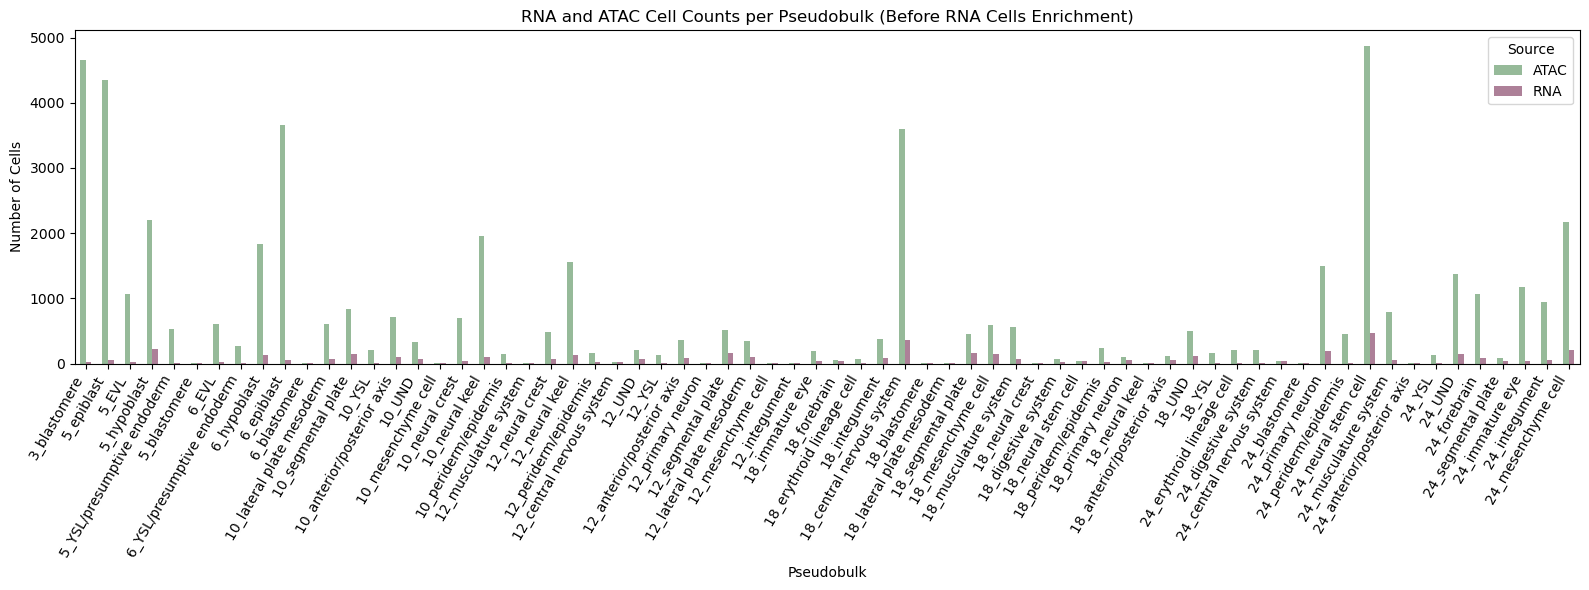

In [ ]:
atac_counts = atac_metadata_df.groupby('pseudobulk')['atac_cell'].nunique().reset_index(name='ATAC')
rna_counts = atac_metadata_df.groupby('pseudobulk')['rna_matching_cell'].nunique().reset_index(name='RNA')

stacked_counts = pd.merge(atac_counts, rna_counts, on='pseudobulk', how='outer').fillna(0)
stacked_counts[['ATAC', 'RNA']] = stacked_counts[['ATAC', 'RNA']].astype(int)
# Extract the numeric prefix from pseudobulk names and convert to integer
stacked_counts['sort_key'] = stacked_counts['pseudobulk'].str.extract('^(\d+)').astype(int)

stacked_counts_sorted = stacked_counts.sort_values('sort_key')

ax = stacked_counts_sorted.set_index('pseudobulk')[['ATAC', 'RNA']].plot(
    kind='bar',
    stacked=False,
    figsize=(16, 6),
    color=['#96ba99', '#ad8098']
)

plt.xticks(rotation=60, ha='right')
plt.xlabel('Pseudobulk')
plt.ylabel('Number of Cells')
plt.title('RNA and ATAC Cell Counts per Pseudobulk (Before RNA Cells Enrichment)')
plt.legend(title='Source')
plt.tight_layout()

fig_path = '../../data/embryo/rna_atac_cell_counts_per_pseudobulk_before_enrichment.png'
plt.savefig(fig_path, bbox_inches='tight')
plt.show()



Plot the amount of cells in through cell trajectories 

In [ ]:
# Three-Panel ATAC vs RNA Developmental Trajectory Comparison
atac_counts_per_psd = atac_metadata_df.groupby('pseudobulk')['atac_cell'].nunique().reset_index(name='ATAC')
# filter out pseudobulks with less than 20 cells
atac_counts_per_psd = atac_counts_per_psd[atac_counts_per_psd['ATAC'] >= 20]
rna_counts_per_psd = atac_metadata_df.groupby('pseudobulk')['rna_matching_cell'].nunique().reset_index(name='RNA')
rna_counts_per_psd = rna_counts_per_psd[rna_counts_per_psd['RNA'] >= 20]
stages_per_celltype = atac_metadata_df.groupby('atac_cell_type')['atac_stage'].unique().reset_index()
stages_per_celltype.rename(columns={'atac_stage': 'stages'}, inplace=True)

stages_per_celltype.sort_values(by='stages', key=lambda x: x.str.len(), ascending=False, inplace=True)
def get_cell_counts_per_stage(row):
    cell_type = row['atac_cell_type']
    stages = row['stages']
    
    cell_counts = []
    for stage in stages:
        pseudobulk_id = f"{stage}_{cell_type}"
        count = atac_metadata_df[atac_metadata_df['pseudobulk'] == pseudobulk_id]['atac_cell'].nunique()
        cell_counts.append(count)
    
    return cell_counts

stages_per_celltype['cell_counts_per_stage'] = stages_per_celltype.apply(get_cell_counts_per_stage, axis=1)

print("\nStages per cell type with cell counts:")
print(stages_per_celltype)

def extract_stage_number(stage_str):
    """Extract numeric value from stage string (e.g., '10hpf' -> 10)"""
    import re
    match = re.search(r'(\d+)', str(stage_str))
    return int(match.group(1)) if match else 0

def process_trajectory_data(df, cell_type_col, stage_col):
    """Process dataframe to create trajectory data"""
    stage_celltype_counts = df.groupby([cell_type_col, stage_col]).size().reset_index(name='count')
    stage_celltype_counts['stage_numeric'] = stage_celltype_counts[stage_col].apply(extract_stage_number)
    heatmap_data = stage_celltype_counts.pivot(index=cell_type_col, columns='stage_numeric', values='count')
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
    
    return heatmap_data

def get_earliest_stage_unified(cell_type, atac_data, rna_data):
    """Get earliest stage for a cell type across both datasets"""
    earliest = float('inf')

    if atac_data is not None and cell_type in atac_data.index:
        for stage in sorted(atac_data.columns):
            if atac_data.loc[cell_type, stage] > 0:
                earliest = min(earliest, int(stage))
                break
    
    # Check RNA data
    if rna_data is not None and cell_type in rna_data.index:
        for stage in sorted(rna_data.columns):
            if rna_data.loc[cell_type, stage] > 0:
                earliest = min(earliest, int(stage))
                break
    
    return earliest if earliest != float('inf') else 999

def get_earliest_stage_single(row):
    """Get earliest stage for a single dataset"""
    for stage in sorted(row.index):
        if row[stage] > 0:
            return int(stage)
    return float('inf')

def plot_trajectories(ax, cell_types, atac_data, rna_data, all_stages, title, plot_type):
    """Plot trajectories for given cell types"""
    
    if len(cell_types) == 0:
        ax.text(0.5, 0.5, 'No cell types in this category', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
        return
    if plot_type == 'shared':
        cell_types_sorted = sorted(cell_types, 
                                  key=lambda x: get_earliest_stage_unified(x, atac_data, rna_data))
    elif plot_type == 'atac_only':
        cell_types_sorted = sorted(cell_types, 
                                  key=lambda x: get_earliest_stage_unified(x, atac_data, None))
    else:  # rna_only
        cell_types_sorted = sorted(cell_types, 
                                  key=lambda x: get_earliest_stage_unified(x, None, rna_data))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(cell_types_sorted)))
    color_map = {cell_type: colors[i] for i, cell_type in enumerate(cell_types_sorted)}
    
    y_offset = 0
    max_counts = []
    if atac_data is not None:
        max_counts.append(atac_data.values.max())
    if rna_data is not None:
        max_counts.append(rna_data.values.max())
    max_count = max(max_counts) if max_counts else 1000
    
    y_spacing = max(500, max_count * 0.12)
    cell_type_positions = {}
    
    for cell_type in cell_types_sorted:
        cell_color = color_map[cell_type]
        max_y_for_cell = 0
    
        if atac_data is not None and cell_type in atac_data.index:
            atac_y_values = []
            for stage in all_stages:
                if stage in atac_data.columns:
                    atac_y_values.append(atac_data.loc[cell_type, stage])
                else:
                    atac_y_values.append(0)
            
            atac_y_values_offset = [val + y_offset for val in atac_y_values]
            max_y_for_cell = max(max_y_for_cell, max(atac_y_values))
            
            ax.plot(all_stages, atac_y_values_offset, marker='o', linewidth=2.5, 
                   markersize=5, color=cell_color, alpha=0.8, linestyle='-',
                   label=f'{cell_type} (ATAC)' if plot_type == 'shared' else cell_type)
            
            non_zero_stages = [stage for stage, count in zip(all_stages, atac_y_values) if count > 0]
            non_zero_counts = [count + y_offset for count in atac_y_values if count > 0]
            if non_zero_stages:
                ax.scatter(non_zero_stages, non_zero_counts, color=cell_color, 
                          s=50, zorder=5, alpha=0.9, marker='o', edgecolor='white', linewidth=1)
        
        if rna_data is not None and cell_type in rna_data.index:
            rna_y_values = []
            for stage in all_stages:
                if stage in rna_data.columns:
                    rna_y_values.append(rna_data.loc[cell_type, stage])
                else:
                    rna_y_values.append(0)
            
            rna_y_values_offset = [val + y_offset for val in rna_y_values]
            max_y_for_cell = max(max_y_for_cell, max(rna_y_values))
            
            ax.plot(all_stages, rna_y_values_offset, marker='s', linewidth=2.5, 
                   markersize=5, color=cell_color, alpha=0.8, linestyle='--',
                   label=f'{cell_type} (RNA)' if plot_type == 'shared' else cell_type)
            
            non_zero_stages = [stage for stage, count in zip(all_stages, rna_y_values) if count > 0]
            non_zero_counts = [count + y_offset for count in rna_y_values if count > 0]
            if non_zero_stages:
                ax.scatter(non_zero_stages, non_zero_counts, color=cell_color, 
                          s=50, zorder=5, alpha=0.9, marker='s', edgecolor='white', linewidth=1)
        
        cell_type_positions[cell_type] = y_offset
        y_offset += max_y_for_cell + y_spacing
    
    for cell_type, y_pos in cell_type_positions.items():
        ax.text(max(all_stages) + 0.3, y_pos + y_spacing*0.1, cell_type, 
                va='bottom', ha='left', fontsize=9, fontweight='bold',
                color=color_map[cell_type])
    
    # Customize the plot
    ax.set_xlabel('Developmental Stage (hpf)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cell Count', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    
    # Set x-axis
    ax.set_xticks(all_stages)
    ax.set_xticklabels([f'{stage}hpf' for stage in all_stages], rotation=45, ha='right')
    ax.set_xlim(min(all_stages)-0.5, max(all_stages)+1.5)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x')
    for i, y_pos in enumerate(cell_type_positions.values()):
        if i > 0:
            ax.axhline(y=y_pos - y_spacing/2, color='gray', linestyle=':', alpha=0.3)
print("Processing ATAC-seq data...")
try:
    atac_heatmap = process_trajectory_data(atac_metadata_df, 'atac_cell_type', 'atac_stage')
    atac_available = True
    print(f"ATAC data processed: {len(atac_heatmap)} cell types")
except Exception as e:
    print(f"ATAC data not available: {e}")
    atac_available = False
    atac_heatmap = None
rna_heatmap = process_trajectory_data(rna_metadata_df, 'celltype', 'stage')

if atac_available:
    all_cell_types = set(atac_heatmap.index) | set(rna_heatmap.index)
    common_cell_types = set(atac_heatmap.index) & set(rna_heatmap.index)
    atac_only = set(atac_heatmap.index) - set(rna_heatmap.index)
    rna_only = set(rna_heatmap.index) - set(atac_heatmap.index)
    
    # Get all stages (union of both datasets)
    all_stages = sorted(set(atac_heatmap.columns) | set(rna_heatmap.columns))
    
    print(f"\nDataset overlap:")
    print(f"Common cell types: {len(common_cell_types)}")
    print(f"ATAC-only: {len(atac_only)}")
    print(f"RNA-only: {len(rna_only)}")
    print(f"Total unique: {len(all_cell_types)}")
    
else:
    # If no ATAC data, all are RNA-only
    common_cell_types = set()
    atac_only = set()
    rna_only = set(rna_heatmap.index)
    all_stages = sorted(rna_heatmap.columns)

fig, axes = plt.subplots(1, 3, figsize=(24, 16))

plot_trajectories(axes[0], common_cell_types, 
                 atac_heatmap if atac_available else None, 
                 rna_heatmap, all_stages, 
                 f'Shared Cell Types (n={len(common_cell_types)})\nATAC (solid, ○) vs RNA (dashed, □)', 
                 'shared')

plot_trajectories(axes[1], atac_only, 
                 atac_heatmap if atac_available else None, 
                 None, all_stages, 
                 f'ATAC-seq Only (n={len(atac_only)})', 
                 'atac_only')
plot_trajectories(axes[2], rna_only, 
                 None, rna_heatmap, all_stages, 
                 f'RNA-seq Only (n={len(rna_only)})', 
                 'rna_only')

fig.suptitle('Developmental Trajectory Comparison: ATAC-seq vs RNA-seq\n(Sorted by Earliest Appearance)', 
             fontsize=16, fontweight='bold', y=0.98)
if len(common_cell_types) > 0 and atac_available:
    legend_elements = [
        plt.Line2D([0], [0], color='black', linewidth=2, linestyle='-', marker='o', 
                   markersize=6, label='ATAC-seq'),
        plt.Line2D([0], [0], color='black', linewidth=2, linestyle='--', marker='s', 
                   markersize=6, label='RNA-seq')
    ]
    axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig_path = '../../data/embryo/atac_rna_developmental_trajectories_comparison.png'
plt.savefig(fig_path, bbox_inches='tight')
plt.show()




#### Only 2258 RNA cells are assigned to ATAC cells

In [13]:
# filter rna_data_log to only keep the rows with max  value >=4
rna_log_high_genes = rna_data_log[rna_data_log.max(axis=1) >= 4]
rna_log_high_genes

,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmc2a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gnb3a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd164l2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:

# continue with log values anf filtered genes 
# split the rna_data_log into matched and unmatched based on the atac_metadata_df
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_data_matched_all_genes = rna_data_log.loc[:, rna_data_log.columns.intersection(matching_cells)]
rna_data_unmatched_all_genes =rna_data_log.loc[:, ~rna_data_log.columns.isin(matching_cells)]
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_high_genes_Matched = rna_log_high_genes.loc[:, rna_log_high_genes.columns.intersection(matching_cells)]
rna_high_genes_Unmatched = rna_log_high_genes.loc[:, ~rna_log_high_genes.columns.isin(matching_cells)]
print("shape of rna_high_genes_Matched:", rna_high_genes_Matched.shape)
print("shape of rna_high_genes_Unmatched:", rna_high_genes_Unmatched.shape)

rna_high_genes_Unmatched.head()



shape of rna_high_genes_Matched: (9205, 2258)
shape of rna_high_genes_Unmatched: (9205, 66595)


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000


##### Define a cutoff for each pseudobulk as the distance between this (mean vector of same psd cells) and the most distant cell of the same celltype (from any time point).
##### Compute the distance from same cell type cells to each pseudobulk considering only genes with max log expression >=4
    - To enrich the pseudobulks with unmatched RNA cells we will use this cutoff
    - If a new cell has a distance > cutoff, it is more different than any cell of that type used to define the pseudobulk 

In [30]:
def compute_pseudobulk_cutoffs_df(rna_data_matched, atac_metadata, marker_genes_dict=None, cutoff_mode='celltype'):
    metadata = atac_metadata.set_index('rna_matching_cell').loc[rna_data_matched.columns].reset_index(names='rna_matching_cell')
    pseudobulk_names = metadata['pseudobulk'].unique()
    results = []
    
    for pb in pseudobulk_names:
        celltype = metadata[metadata['pseudobulk'] == pb]['atac_cell_type'].iloc[0]
        cells_in_pb = metadata[metadata['pseudobulk'] == pb]['rna_matching_cell']
        same_type_cells = metadata[metadata['atac_cell_type'] == celltype]['rna_matching_cell']
        same_type_pseudobulks = metadata[metadata['atac_cell_type'] == celltype]['pseudobulk'].unique()

        if len(same_type_cells) == 0:
            continue

        if marker_genes_dict is not None:
            marker_genes = marker_genes_dict.get(pb, [])
            marker_genes = [g for g in marker_genes if g in rna_data_matched.index]
            genes_to_use = marker_genes
        else:
            genes_to_use = rna_data_matched.index
        
        mean_expression = rna_data_matched.loc[genes_to_use, cells_in_pb].mean(axis=1)
        mean_vec_reshaped = mean_expression.values.reshape(1, -1)

        if cutoff_mode == 'pseudobulk':
            # Compute distances from cells of the same type to the pseudobulk mean expression vector
            same_type_matrix = rna_data_matched.loc[genes_to_use, same_type_cells].T.values
            distances = cdist(same_type_matrix, mean_vec_reshaped, metric='euclidean').flatten()
            cutoff = distances.max()
        elif cutoff_mode == 'celltype':
            # Compute the mean expression vector of all pseudobulks with the same cell type
            mean_same_type_expression = rna_data_matched.loc[genes_to_use, metadata[metadata['pseudobulk'].isin(same_type_pseudobulks)]['rna_matching_cell']].mean(axis=1)
            mean_same_type_vec_reshaped = mean_same_type_expression.values.reshape(1, -1)
            # Compute distances from all same cell type cells to this mean vector
            same_type_matrix = rna_data_matched.loc[genes_to_use, same_type_cells].T.values
            distances = cdist(same_type_matrix, mean_same_type_vec_reshaped, metric='euclidean').flatten()
            cutoff = distances.max()
        else:
            raise ValueError("Invalid cutoff_mode. Use 'max_distance' or 'mean_distance'.")
        
        results.append({
            'pseudobulk': pb,
            'atac_cell_type': celltype,
            'cutoff': cutoff,
            'n_cells_in_pseudobulk': len(cells_in_pb),
            'n_cells_same_type': len(same_type_cells)
        })
    
    return pd.DataFrame(results)


cutoffs_high_exp_genes_Celltype = compute_pseudobulk_cutoffs_df(rna_high_genes_Matched, atac_metadata_df, cutoff_mode='celltype')
cutoffs_high_exp_genes_Pseudobulk = compute_pseudobulk_cutoffs_df(rna_high_genes_Matched, atac_metadata_df, cutoff_mode='pseudobulk')
print(cutoffs_high_exp_genes_Celltype.head())
print(cutoffs_high_exp_genes_Pseudobulk.head())

                  pseudobulk          atac_cell_type      cutoff  \
0             12_neural keel             neural keel  146.972241   
1  18_central nervous system  central nervous system  173.703086   
2            10_neural crest            neural crest  118.172175   
3            12_neural crest            neural crest  118.172175   
4              12_integument              integument  137.452094   

   n_cells_in_pseudobulk  n_cells_same_type  
0                   1557               3525  
1                   3599               3672  
2                    694               1177  
3                    478               1177  
4                     10               1336  
                  pseudobulk          atac_cell_type      cutoff  \
0             12_neural keel             neural keel  138.797406   
1  18_central nervous system  central nervous system  173.781686   
2            10_neural crest            neural crest  118.594639   
3            12_neural crest            neu

Create mean and std fataframes for RNA -only for the pseudobulks with more than 10 ATAC cells
- keep the pseudobulks with a few RNA original assignments since the marker genes will be computed according to all time points of the same pseudobulk

In [33]:
def create_rna_mean(rna_data, atac_metadata_df, valid_pseudobulks):
    cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
    rna_data_psd = rna_data.rename(columns=cell_to_pseudobulk)
    rna_data_filtered = rna_data_psd.loc[:, rna_data_psd.columns.intersection(valid_pseudobulks)]
    return rna_data_filtered.groupby(level=0, axis=1).mean()

def create_rna_std(rna_data, atac_metadata_df, valid_pseudobulks):
    cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
    rna_data_psd = rna_data.rename(columns=cell_to_pseudobulk)
    rna_data_filtered = rna_data_psd.loc[:, rna_data_psd.columns.intersection(valid_pseudobulks)]
    return rna_data_filtered.groupby(level=0, axis=1).std()

valid_pseudobulks = atac_mean_filtered.columns

rna_mean_filtered_genes = create_rna_mean(rna_high_genes_Matched, atac_metadata_df, valid_pseudobulks)
rna_std_filtered_genes = create_rna_std(rna_high_genes_Unmatched, atac_metadata_df, valid_pseudobulks)
rna_mean_all_genes = create_rna_mean(rna_data_matched_all_genes, atac_metadata_df, valid_pseudobulks)
rna_std_all_genes = create_rna_std(rna_data_matched_all_genes, atac_metadata_df, valid_pseudobulks)



/tmp/ipykernel_4156765/665281381.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).mean()
/tmp/ipykernel_4156765/665281381.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).std()
/tmp/ipykernel_4156765/665281381.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).mean()
/tmp/ipykernel_4156765/665281381.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).std()


In [39]:
rna_mean_filtered_genes

,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,12_UND,12_YSL,...,24_segmental plate,3_blastomere,5_EVL,5_YSL/presumptive endoderm,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_epiblast,6_hypoblast
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.084864,2.292481,5.977550,5.505295,5.860131,5.471751,4.346743,5.809875,5.433258,1.584963,...,5.729210,2.850926,4.662160,1.935785,2.623231,3.276358,4.178352,1.905843,4.253723,3.285158
khdrbs1a,4.742312,3.284928,6.498762,6.354888,6.985411,6.233713,2.729716,6.072204,5.686432,3.700440,...,5.015834,5.354773,7.578096,3.043094,6.082239,6.388591,6.952145,4.021294,6.490304,6.263180
apoeb,2.446045,6.575984,4.891290,4.907480,6.666729,4.654771,0.000000,4.813227,3.869535,0.000000,...,4.124131,2.321131,2.223308,5.098626,4.674749,4.360641,1.392333,5.915131,5.619259,4.404523
cfl1,3.911818,2.292481,4.642868,4.655234,4.435093,4.392690,0.000000,4.284868,4.602898,3.000000,...,3.988292,4.364861,5.546121,2.194988,3.169378,3.684791,4.788534,2.364896,4.009630,3.561034
polr2d,1.181378,0.000000,1.874917,1.880436,1.776963,1.805762,0.000000,1.900582,1.602456,0.000000,...,1.472313,1.321714,1.166667,0.000000,0.628456,1.095659,0.685348,0.250000,1.641023,1.037416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmc2a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gnb3a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd164l2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### assign pseudobulk labels on unmatched cells 
        - considering all genes
        - considering only the genees with argmax log2(x+1) >4

In [ ]:
from collections import Counter

def analyze_distance_changes(cell_to_distance_filtered, cell_to_distance_all, 
                                     cell_to_pseudobulk_filtered, cell_to_pseudobulk_all,
                                     title=""):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle(f'Distance Analysis: Filtered vs All Genes\n{title}', fontsize=16, fontweight='bold')

    common_cells = set(cell_to_distance_filtered) & set(cell_to_distance_all)
    distances_filtered = [cell_to_distance_filtered[cell] for cell in common_cells]
    distances_all = [cell_to_distance_all[cell] for cell in common_cells]

    axes[0].hist(distances_filtered, bins=30, alpha=0.7, label='Filtered genes', color='red', density=True)
    axes[0].hist(distances_all, bins=30, alpha=0.7, label='All genes', color='blue', density=True)
    
    axes[0].set_xlabel('Distance to closest pseudobulk')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distance Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(distances_all, distances_filtered, alpha=0.6, s=20)
    axes[1].plot([min(distances_all), max(distances_all)],
                 [min(distances_all), max(distances_all)], 'r--', label='y = x')
    axes[1].set_xlabel('Distance (All genes)')
    axes[1].set_ylabel('Distance (Filtered genes)')
    axes[1].set_title('Distance Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    correlation = np.corrcoef(distances_all, distances_filtered)[0, 1]
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                 transform=axes[1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

    pseudobulk_counts_filtered = Counter(cell_to_pseudobulk_filtered.values())
    pseudobulk_counts_all = Counter(cell_to_pseudobulk_all.values())
    all_pseudobulks = sorted(set(pseudobulk_counts_filtered) | set(pseudobulk_counts_all))

    counts_filtered = [pseudobulk_counts_filtered.get(pb, 0) for pb in all_pseudobulks]
    counts_all = [pseudobulk_counts_all.get(pb, 0) for pb in all_pseudobulks]

    x_pos = np.arange(len(all_pseudobulks))
    width = 0.35

    axes[2].bar(x_pos - width / 2, counts_filtered, width, label='Filtered genes', color='red', alpha=0.7)
    axes[2].bar(x_pos + width / 2, counts_all, width, label='All genes', color='blue', alpha=0.7)
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(all_pseudobulks, rotation=45, ha='right')
    axes[2].set_xlabel('Pseudobulk')
    axes[2].set_ylabel('Assigned cells')
    axes[2].set_title('Pseudobulk Assignment Counts')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return {
        'distances_filtered': distances_filtered,
        'distances_all': distances_all,
        'correlation': correlation
    }
results = analyze_distance_changes(
    cell_to_distance_filtered_genes,
    cell_to_distance_all_genes,
    cell_to_pseudobulk_filtered_genes,
    cell_to_pseudobulk_all_genes,
    title="Unmatched RNA cells assigned to pseudobulks: Filtered: High Expression Genes vs All Genes \n No Marker genes"
)


#### Some pseudobulks have 0 marker genes - they also have few cells assigned from the original assignment

In [48]:
def find_marker_genes(rna_data, metadata_df, grouping_column, 
                     cell_id_column='rna_matching_cell',
                     pvalue_threshold=0.05, log_fc_threshold=0.5):
    
    # Create cell-to-group mapping and rename columns
    cell_to_group = metadata_df.set_index(cell_id_column)[grouping_column].to_dict()
    rna_data_grouped = rna_data.rename(columns=cell_to_group)
    
    # Compute group-level statistics
    group_counts = rna_data_grouped.columns.value_counts()
    rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
    rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
    
    # Perform t-tests for each group
    genes = rna_data_mean_group.index
    groups = rna_data_mean_group.columns
    marker_genes = {}
    
    for target_group in groups:        
        other_groups = [group for group in groups if group != target_group]
        
        # Extract statistics for target group
        mu1 = rna_data_mean_group[target_group]
        sd1 = rna_data_std_group[target_group]
        n1 = group_counts[target_group]
        
        # Extract statistics for other groups (averaged)
        mu2 = rna_data_mean_group[other_groups].mean(axis=1)
        sd2 = rna_data_std_group[other_groups].mean(axis=1)
        n2 = group_counts[other_groups].mean()
        
        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        
        # Handle division by zero and infinite values
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        # Calculate two-tailed p-values
        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        
        # FDR correction
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")
        
        # Calculate log fold-change
        log_fc = mu1 - mu2
        
        # Filter significant marker genes
        mask = (pvals_corrected < pvalue_threshold) & (log_fc > log_fc_threshold)
        marker_genes[target_group] = list(genes[mask])

    
    return marker_genes



marker_genes_celltype = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='atac_cell_type',
    pvalue_threshold=0.05,
    log_fc_threshold=0.0
)

marker_genes_pseudobulk = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)

marker_genes_celltype_high_exp_genes= find_marker_genes(
    rna_data=rna_high_genes_Matched,
    metadata_df=atac_metadata_df,
    grouping_column='atac_cell_type',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)

marker_genes_pseudobulk_high_exp_genes= find_marker_genes(
    rna_data=rna_high_genes_Matched,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)
marker_genes_celltype_high_exp_genes

/tmp/ipykernel_4156765/37949239.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_4156765/37949239.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
/tmp/ipykernel_4156765/37949239.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_4156765/37949239.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
/tmp/ipykernel_4156765/37949239.py:11: Futur

{'EVL': ['khdrbs1a',
  'cfl1',
  'ppp2cb',
  'twistnb',
  'xrn2',
  'NC-002333.4',
  'hmgb2b',
  'smc1al',
  'seta',
  'hmga1a',
  'si:ch73-281n10.2',
  'eef1a1l1',
  'sltm',
  'top1l',
  'CR383676.2',
  'gnaia',
  'ncl',
  'hnrnpabb',
  'srsf6b',
  'bzw1b',
  'sarnp',
  'hmgb2a',
  'h3f3b.1',
  'ilf3b',
  'siva1',
  'myef2',
  'smarca4a',
  'khdrbs1b',
  'actb2',
  'tmsb4x',
  'setb',
  'h2az2b',
  'anp32e',
  'slbp',
  'bcap31',
  'arih1l',
  'hnrnpm',
  'rrm2',
  'lsm6',
  'med6',
  'lrrc8aa',
  'hnrnpaba',
  'C3H16orf72',
  'supt16h',
  'cirbpa',
  'morf4l1',
  'pdcd11',
  'ccdc32',
  'ybx1',
  'usp10',
  'zgc:55558',
  'rhoaa',
  'sall4',
  'cbx1a',
  'cirbpb',
  'pfn1',
  'hnrnpa0a',
  'ik',
  'psenen',
  'rasal2',
  'srprb',
  'cox4i1',
  'hnrnpa1a',
  'mvp',
  'mt-co2',
  'hnrnpa1b',
  'api5',
  'ddx19',
  'srsf5a',
  'alyref',
  'ddx18',
  'arf1',
  'plcg1',
  'arglu1a',
  'CABZ01044053.1',
  'si:dkey-67c22.2',
  'hnrnpa0b',
  'scaf4b',
  'tmem147',
  'h3f3d',
  'sae1',
  'ssb

In [63]:
marker_genes_set = marker_genes_celltype_high_exp_genes.values()
marker_genes_set = {gene for sublist in marker_genes_set for gene in sublist}
len(marker_genes_set)

8306

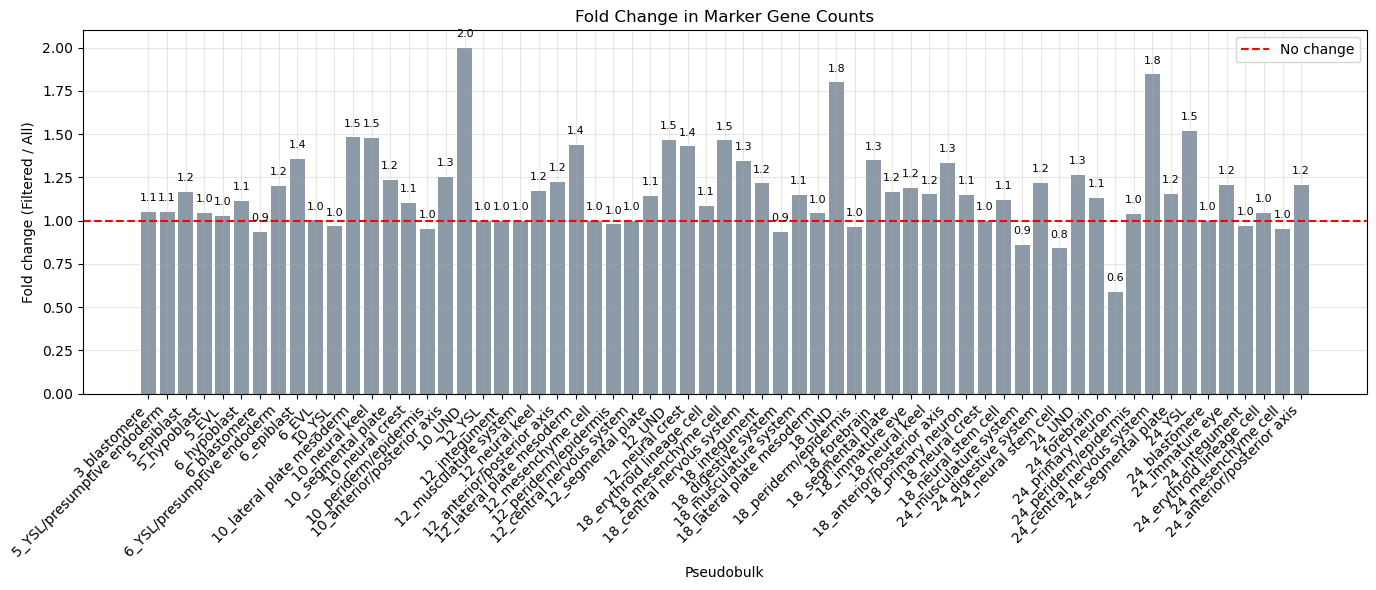

In [30]:
def plot_marker_gene_fold_change(marker_genes_all, marker_genes_filtered, title="Fold Change in Marker Gene Counts"):
    def extract_stage(group_name):
        try:
            return int(group_name.split('_')[0])
        except:
            return float('inf')

    all_groups = set(marker_genes_all.keys()) | set(marker_genes_filtered.keys())
    sorted_groups = sorted(all_groups, key=extract_stage)

    fold_changes = []
    for group in sorted_groups:
        count_all = len(marker_genes_all.get(group, []))
        count_filtered = len(marker_genes_filtered.get(group, []))
        if count_all > 0:
            fc = count_filtered / count_all
        else:
            fc = float('inf') if count_filtered > 0 else 1
        fold_changes.append(fc)

    capped_fc = [min(fc, 2.0) if fc != float('inf') else 2.0 for fc in fold_changes]

    plt.figure(figsize=(14, 6))
    bars = plt.bar(sorted_groups, capped_fc, alpha=0.8, color='slategrey')
    plt.axhline(1.0, color='red', linestyle='--', label='No change')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Pseudobulk")
    plt.ylabel("Fold change (Filtered / All)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)

    for bar, fc in zip(bars, fold_changes):
        label = f"{fc:.1f}" if fc != float('inf') else "inf"
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05, 
                 label, ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_marker_gene_counts(marker_genes_dict, title="Number of Marker Genes per Pseudobulk"):
    def extract_stage(group_name):
        try:
            return int(group_name.split('_')[0])
        except:
            return float('inf')

    sorted_groups = sorted(marker_genes_dict.keys(), key=extract_stage)
    counts = [len(marker_genes_dict[group]) for group in sorted_groups]

    plt.figure(figsize=(14, 6))
    bars = plt.bar(sorted_groups, counts, alpha=0.8, color='steelblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Pseudobulk")
    plt.ylabel("Number of Marker Genes")
    plt.title(title)
    plt.grid(True, alpha=0.3)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                 str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


results = plot_marker_gene_fold_change(
    marker_genes_pseudobulk, 
    marker_genes_pseudobulk_high_exp_genes,
)


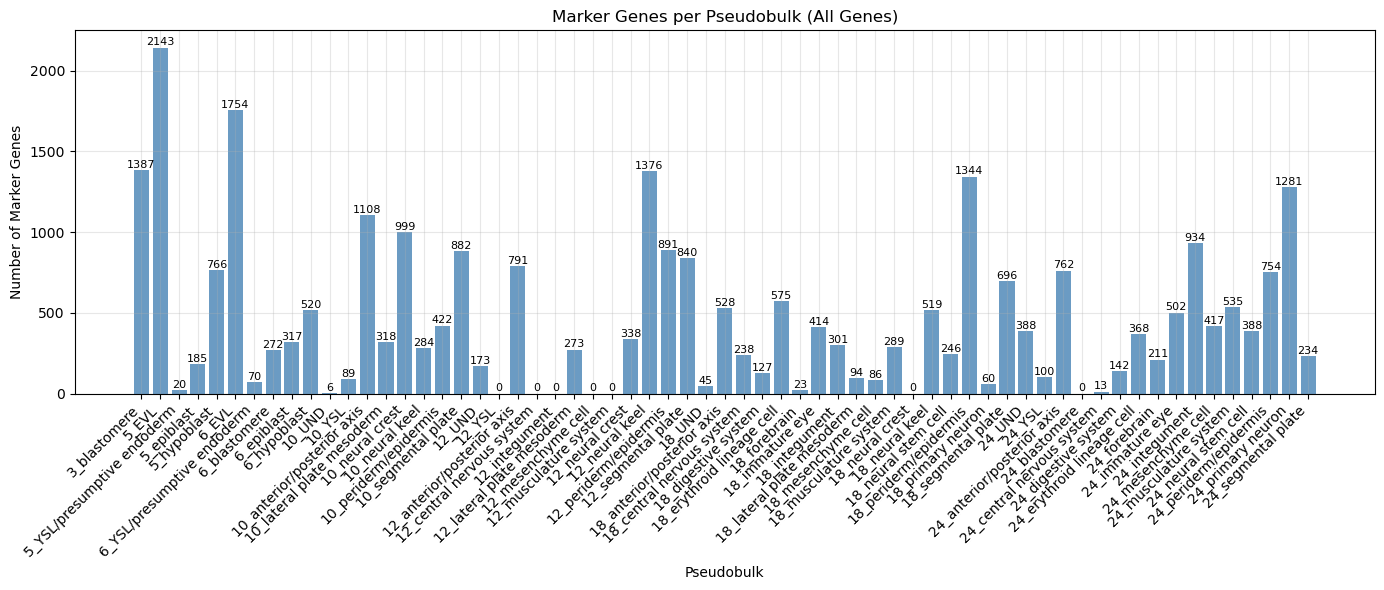

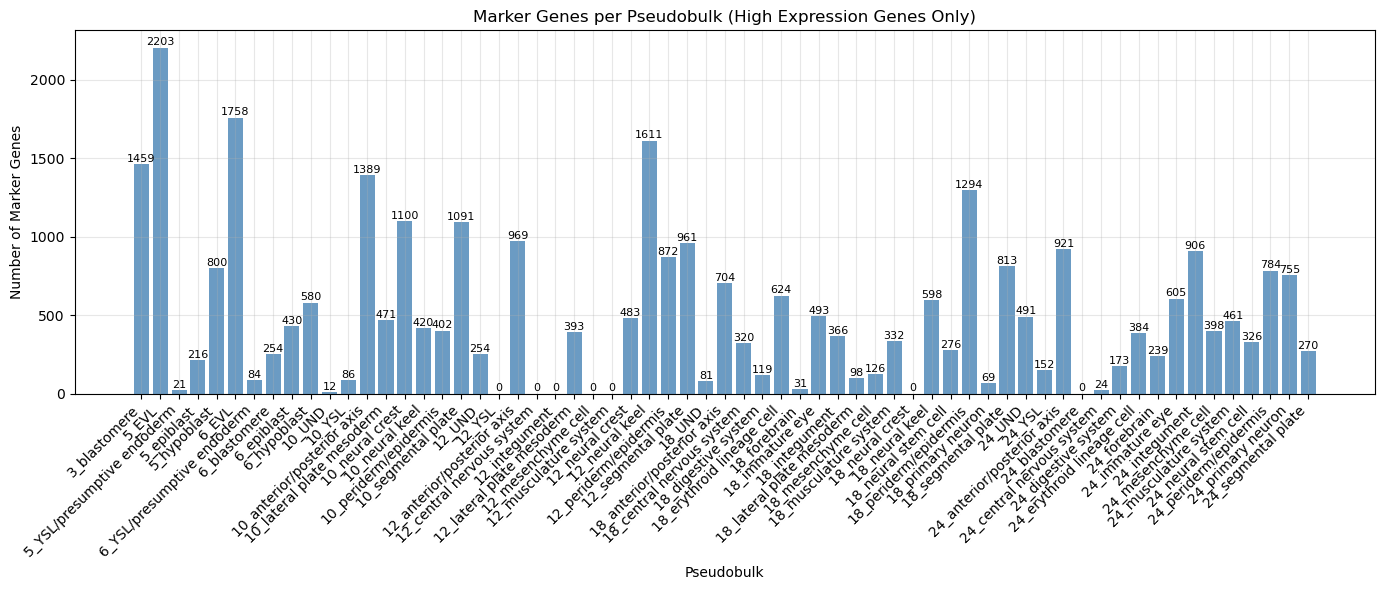

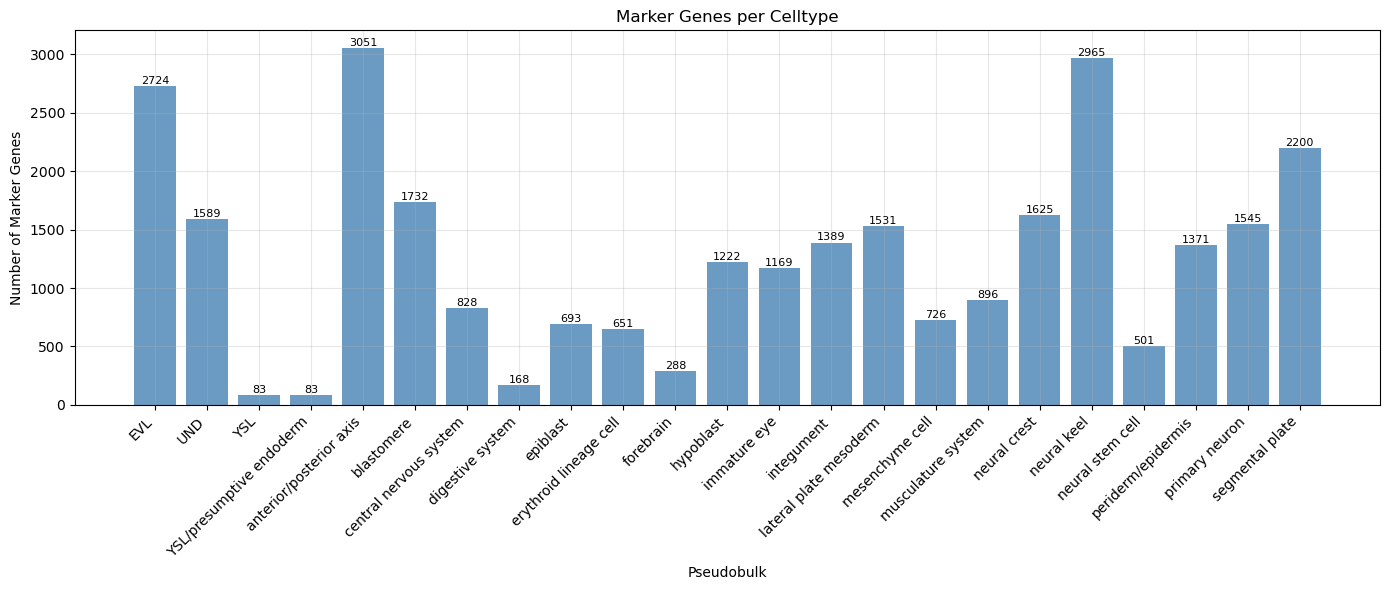

In [31]:

plot_marker_gene_counts(marker_genes_pseudobulk, title="Marker Genes per Pseudobulk (All Genes)")
plot_marker_gene_counts(marker_genes_pseudobulk_high_exp_genes, title="Marker Genes per Pseudobulk (High Expression Genes Only)")
plot_marker_gene_counts(marker_genes_celltype, title="Marker Genes per Celltype")





In [68]:
# filter rows of rna_mean_filtereed_genes to only keep rows that are in marker_genes_set
rna_mean_markers = rna_mean_filtered_genes.loc[rna_mean_filtered_genes.index.intersection(marker_genes_set)]
rna_mean_markers
# filter rna_high_genes_Unmatched to have the same genes as rna_mean_markers
rna_high_genes_Unmatched_markers = rna_high_genes_Unmatched.loc[rna_high_genes_Unmatched.index.intersection(marker_genes_set)]
rna_high_genes_Unmatched_markers

,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cdk5r2a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
slc12a5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
he1.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
def assign_cells_to_pseudobulks(rna_data_unmatched, rna_data_mean_pseudobulk):
    unmatched_matrix = rna_data_unmatched.T.values 
    pseudobulk_matrix = rna_data_mean_pseudobulk.T.values 
    distance_matrix = cdist(unmatched_matrix, pseudobulk_matrix, metric='euclidean')
    pseudobulk_names = list(rna_data_mean_pseudobulk.columns)
    cell_names = list(rna_data_unmatched.columns)
    closest_indices = np.argmin(distance_matrix, axis=1)
    closest_pseudobulks = [pseudobulk_names[i] for i in closest_indices]
    closest_distances = distance_matrix[np.arange(len(cell_names)), closest_indices]
    cell_to_pseudobulk = dict(zip(cell_names, closest_pseudobulks))
    cell_to_distance = dict(zip(cell_names, closest_distances))

    return cell_to_pseudobulk, cell_to_distance

cell_to_pseudobulk_filtered_genes, cell_to_distance_filtered_genes = assign_cells_to_pseudobulks(rna_high_genes_Unmatched_markers, rna_mean_markers)
cell_to_pseudobulk_all_genes,cell_to_distance_all_genes= assign_cells_to_pseudobulks(rna_data_unmatched_all_genes, rna_mean_all_genes)
print(cell_to_distance_filtered_genes)
print(cell_to_distance_all_genes)

#### Assign each unmatched RNA cell to the pseudobulk with the minimum euyclidean distance 
- use only genes with log2(x+1) expression >= 4 for at least one pseudobulk

- use only pseudobulk specific marker genes for each iteration

#### replace cell column names in rna_data_log with the values of the dictionaries 
    - cell_to_psd_with_markers for unmatched cells 
    - cell_to_psd_with_markers for matched_cells

#### group by pseudobulk name and the mean values 

In [64]:
rna_high_genes_Unmatched

,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmc2a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gnb3a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd164l2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### plot the number of cells in unmatched and matched pseudobulks

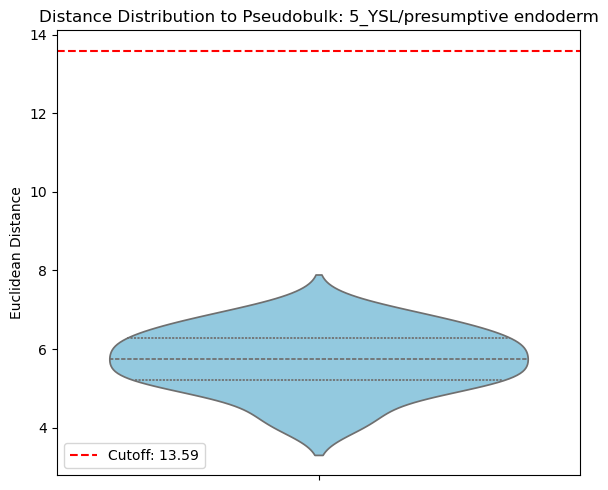

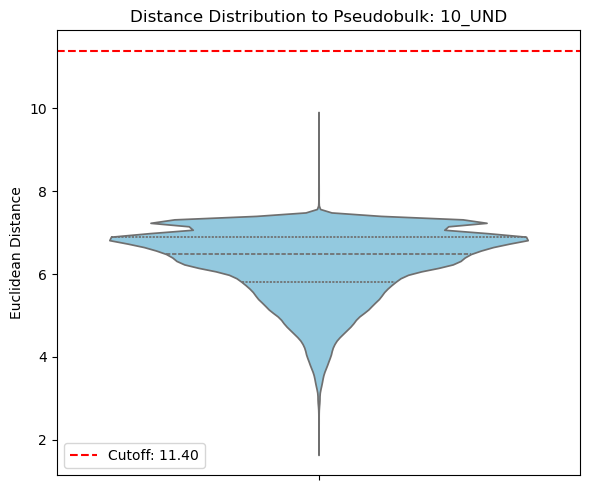

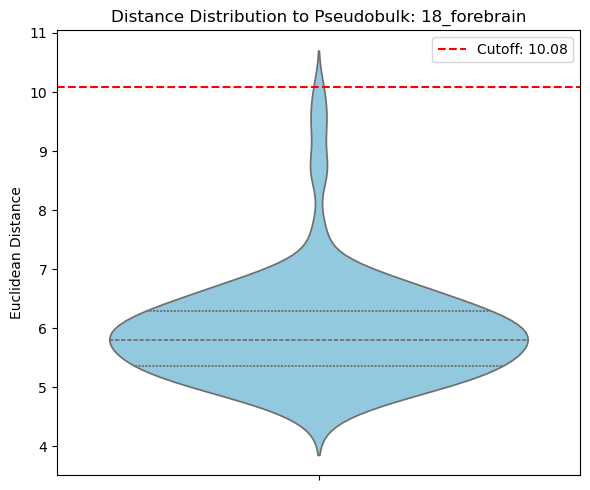

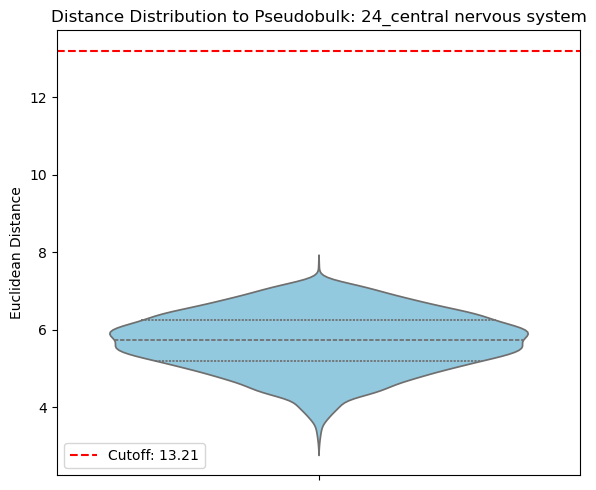

In [ ]:
import os

def plot_distance_distributions_separately(cell_to_psd_with_markers, 
                                           cell_to_psd_dist_with_markers,
                                           cutoffs_df,
                                           output_dir="distance_violin_plots"):
    os.makedirs(output_dir, exist_ok=True)

    # Create a dataframe with all distances and pseudobulk assignments
    df = pd.DataFrame({
        "cell": list(cell_to_psd_with_markers.keys()),
        "pseudobulk": [cell_to_psd_with_markers[c] for c in cell_to_psd_with_markers],
        "distance": [cell_to_psd_dist_with_markers[c] for c in cell_to_psd_with_markers]
    })

    # For each pseudobulk, plot a violin plot of distances
    unique_pseudobulks = sorted(df['pseudobulk'].unique(), key=lambda x: int(x.split("_")[0]) if x.split("_")[0].isdigit() else 999)

    for pb in unique_pseudobulks:
        sub_df = df[df['pseudobulk'] == pb]
        cutoff = cutoffs_df[cutoffs_df['pseudobulk'] == pb]['cutoff'].values[0] if pb in cutoffs_df['pseudobulk'].values else None

        plt.figure(figsize=(6, 5))
        sns.violinplot(data=sub_df, y='distance', inner='quartile', color='skyblue')
        plt.title(f"Distance Distribution to Pseudobulk: {pb}")
        plt.ylabel("Euclidean Distance")
        if cutoff:
            plt.axhline(y=cutoff, color='red', linestyle='--', label=f'Cutoff: {cutoff:.2f}')
            plt.legend()

        plt.tight_layout()
        # Sanitize filename by replacing "/" and spaces
        filename_safe_pb = pb.replace("/", "_").replace(" ", "_")
        plt.savefig(os.path.join(output_dir, f"{filename_safe_pb}_distance_violin.png"))


plot_distance_distributions_separately(
    cell_to_psd_with_markers,
    cell_to_psd_Dist_with_markers,
    cutoffs_marker_based,
    output_dir="distance_violin_plots"
)



In [ ]:

def plot_volcano_plots(mean_df, std_df, sample_sizes, marker_dict, title_prefix="Pseudobulk"):
    genes = mean_df.index
    pseudobulks = mean_df.columns

    for target_pb in pseudobulks:
        other_pbs = [pb for pb in pseudobulks if pb != target_pb]

        mu1 = mean_df[target_pb]
        sd1 = std_df[target_pb]
        n1 = sample_sizes[target_pb]

        mu2 = mean_df[other_pbs].mean(axis=1)
        sd2 = std_df[other_pbs].mean(axis=1)
        n2 = sample_sizes[other_pbs].mean()

        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

        log_fc = mu1 - mu2

        plt.figure(figsize=(8, 6))
        plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
        
        # Highlight marker genes
        marker_genes = marker_dict[target_pb]
        marker_mask = mean_df.index.isin(marker_genes)
        plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')

        plt.title(f"{title_prefix}: {target_pb}")
        plt.xlabel("Log2 Fold Change")
        plt.ylabel("-log10(FDR-corrected p-value)")
        plt.axhline(-np.log10(0.05), color='grey', linestyle='--', linewidth=1)
        plt.axvline(0.5, color='grey', linestyle='--', linewidth=1)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Call the volcano plot function for pseudobulks
plot_volcano_plots(rna_data_mean_pseudobulk_og_filtered_genes, rna_data_std_pseudobulk_og_filtered_genes, pseudobulk_counts_og, marker_genes_pseudobulk_high_exp_genes, title_prefix="Pseudobulk")

